# Deep Learning HW2

Gerald Baulig 0780827 2019/12/02

GitHub: https://github.com/bugerry87/fcnn_scratch

---

In this assignment we were asked to implement a Convolutional Neural Network (CNN) from scratch.
The CNN has to be demonstrated on two datasets:

1. The MNIST dataset of handwritten digits, and
2. The CIFAR-10 dataset with tiny images of 10 different classes.

# A CNN from Scratch


## Smart Indexing

In [29]:
import numpy as np
import numpy.matlib

def indices(xs, ks, stride=(1,1)):
    kn, kv, ku, kc = ks
    xn, xv, xu, xc = xs
    sv, su = stride
    
    def base(u, k, s):
        u = u+1-k
        K = np.arange(0, k)
        U = np.arange(0, u, s)
        us = U.size
        i = np.tile(K, us).reshape(us, k) + np.repeat(U, k).reshape(us, k)
        return i
    
    u = base(xu, ku, su)
    if xv == xu and kv == ku:
        v = u.copy()
    else:
        v = base(xv, kv, sv)
    
    shape = (max(v.shape[0],1), max(u.shape[0],1))
    u = np.matlib.repmat(u, shape[0], kv*xc).T
    v = np.repeat(v, ku*xc, axis=1)
    v = np.repeat(v, shape[1], axis=0).T
    
    n = np.tile(np.arange(xn), kv*ku)[:,None] if xn > 1 else 0
    v = v if np.any(v) else 0
    u = u if np.any(u) else 0
    c = np.tile(np.arange(xc), kv*ku)[:,None] if xc > 1 else 0
    return n, v, u, c, shape

## Test
def test_Indices():
    r = np.reshape(np.arange(5*5), (5,5))
    print("R: ", r.shape, "\n", r)
    n, v, u, c, shape = indices((1,5,5,1),(1,3,3,1),(1,1))
    print("U: ", u.shape, "\n", u)
    print("V: ", v.shape, "\n", v)
    r = r[v, u]
    print("R': ", r.shape, "\n", r)
test_Indices()

R:  (5, 5) 
 [[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]
 [15 16 17 18 19]
 [20 21 22 23 24]]
U:  (9, 9) 
 [[0 1 2 0 1 2 0 1 2]
 [1 2 3 1 2 3 1 2 3]
 [2 3 4 2 3 4 2 3 4]
 [0 1 2 0 1 2 0 1 2]
 [1 2 3 1 2 3 1 2 3]
 [2 3 4 2 3 4 2 3 4]
 [0 1 2 0 1 2 0 1 2]
 [1 2 3 1 2 3 1 2 3]
 [2 3 4 2 3 4 2 3 4]]
V:  (9, 9) 
 [[0 0 0 1 1 1 2 2 2]
 [0 0 0 1 1 1 2 2 2]
 [0 0 0 1 1 1 2 2 2]
 [1 1 1 2 2 2 3 3 3]
 [1 1 1 2 2 2 3 3 3]
 [1 1 1 2 2 2 3 3 3]
 [2 2 2 3 3 3 4 4 4]
 [2 2 2 3 3 3 4 4 4]
 [2 2 2 3 3 3 4 4 4]]
R':  (9, 9) 
 [[ 0  1  2  5  6  7 10 11 12]
 [ 1  2  3  6  7  8 11 12 13]
 [ 2  3  4  7  8  9 12 13 14]
 [ 5  6  7 10 11 12 15 16 17]
 [ 6  7  8 11 12 13 16 17 18]
 [ 7  8  9 12 13 14 17 18 19]
 [10 11 12 15 16 17 20 21 22]
 [11 12 13 16 17 18 21 22 23]
 [12 13 14 17 18 19 22 23 24]]


In [25]:
def padding(X, pad=(0,1,1,0)):
    shape = np.array(X.shape, dtype=int) + np.array(pad)*2
    Xp = np.zeros(shape)
    Xp[:, 1:-1, 1:-1,:] = X
    return Xp

## Test
def test_padding():
    Xp = padding(np.ones((1,5,5,1)))
    print(Xp[0,:,:,0])
test_padding()

[[0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 1. 1. 0.]
 [0. 1. 1. 1. 1. 1. 0.]
 [0. 1. 1. 1. 1. 1. 0.]
 [0. 1. 1. 1. 1. 1. 0.]
 [0. 1. 1. 1. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]


## The Kernel Convolution


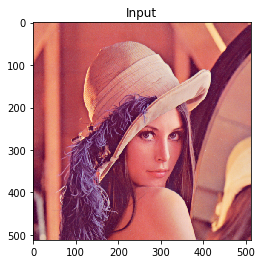

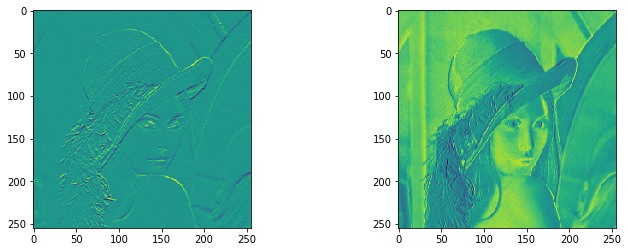

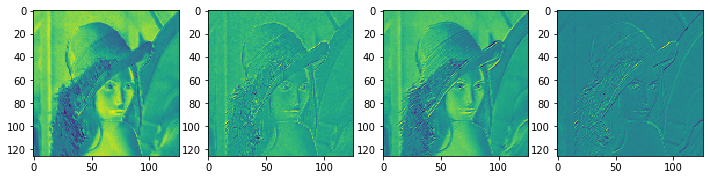

In [53]:
import numpy as np
from mynn import FeedFunc

def shape_nvuc(arr):
    if arr.ndim == 4:
        pass
    elif arr.ndim == 2:
        arr = arr[None,:,:,None]
    elif arr.ndim == 3:
        arr = arr[None,:,:,:]
    else:
        raise ValueError("Matrix should have atleast 2dims!")
    return arr, np.array(arr.shape, dtype=int)

class Conv2D(FeedFunc):
    def __init__(self, stride=(1,1), norm=(), cache=True):
        self.stride = stride
        self.norm = norm if isinstance(norm, tuple) else tuple(norm)
        self.cache = cache
        self.uptodate = False
        pass
    
    def f(self, X, K, cache=True):
        X, xs = shape_nvuc(X)
        K, ks = shape_nvuc(K)
        
        if self.cache and cache:
            if not self.uptodate:
                self.n, self.v, self.u, self.c, self.shape = indices(xs, ks, self.stride)
                self.uptodate = True
            n, v, u, c, shape = (self.n, self.v, self.u, self.c, self.shape)
        else:
            n, v, u, c, shape = indices(xs, ks, self.stride)
        
        K = K.reshape(ks[0],-1)
        X = X[:,v,u,c].reshape(K.shape[1], -1)
        
        Y = np.dot(K, X)
        Y = Y.reshape(xs[0], ks[0], shape[0], shape[1]).transpose(0,2,3,1)
         
        for norm in self.norm:
            if norm is 'Merge':
                Y = np.sum(Y, axis=3, keepdims=True)

            elif norm is 'Swap':
                Y = Y.transpose(3,1,2,0)

            elif norm is 'Mean':
                Y -= Y.mean(axis=(0,1,2))

            elif norm is 'CamReady':
                Y /= np.abs(Y).max(axis=(0,1,2)) * 2
                Y += 0.5
            
            elif norm is 'Squeeze':
                Y = np.squeeze(Y)
        return Y
    
    def dw(self, X, dZ):
        print("dw---------")
        xs = X.shape
        zs = dZ.shape
        n, v, u, c, shape = indices(xs, zs)
        
        print("dZ:", zs)
        print("X:", xs)
        
        dZ = dZ.reshape(-1,zs[0])
        X = X[:,v,u,c].reshape(dZ.shape[1], -1)
        Y = np.dot(dZ, X)
        print("dZ:", dZ.shape, "* X:", X.shape, "= dY:", Y.shape)
        Y = Y.reshape(xs[3], zs[3], shape[0], shape[1]).transpose(0,2,3,1)
        
        return Y
    
    def dz(self, dZ, K):
        print("dz---------")
        zs = dZ.shape
        ks = K.shape
        n, v, u, c, shape = indices(zs, ks)
        
        K = K.reshape(ks[1]*ks[2]*ks[3], -1)
        dZ = dZ[:,v,u,c].reshape(K.shape[1], -1)
        Y = np.dot(K, dZ)
        print("K:", K.shape, "* dZ:", dZ.shape, "= dY:", Y.shape)
        
        Y = Y.reshape(zs[0], ks[0], shape[0], shape[1]).transpose(0,2,3,1)
        print("dY", Y.shape)
        
        
        return Y

##test
def test_Conv2D():
    %matplotlib inline
    import matplotlib.pylab as plt
    from PIL import Image
    
    x = np.asarray(Image.open('Lenna.png'), dtype=float) / 255

    kl1 = np.zeros((2,3,3,3)) ##create 2 3*3kernels with 3 channels
    kl1[0,0,:,:] = -1.
    kl1[0,2,:,:] = 1. ##horz. haar line filter
    kl1[1,:,:,:] = -0.5
    kl1[1,:,:,0] = 1. ##red filter
    
    np.random.seed(108)
    kl2 = np.random.randn(4,4,4,2)

    conv1 = Conv2D((2,2), ('CamReady'))
    conv2 = Conv2D((2,2), ('CamReady'))
    yl1 = conv1.f(x, kl1)
    yl2 = conv2.f(yl1, kl2)

    ## viz
    plt.imshow(x)
    plt.title('Input')
    plt.show()

    fig = plt.figure(figsize=(12,4))
    ax = fig.subplots(1,2)
    for i, a in enumerate(ax):
        a.imshow(yl1[0,:,:,i])
    plt.show()

    fig = plt.figure(figsize=(12,4))
    ax = fig.subplots(1,4)
    for i, a in enumerate(ax):
        a.imshow(yl2[0,:,:,i])
    plt.show()
test_Conv2D()

In [54]:
from mynn.Tools import train_n_plot

np.random.seed(1)
epochs = 1
batch_size = 2
lr = 1e-10
lr_dec = 1e-1
model_name = "mnist_cnn"
ckpts = 1

cnn = init_MNIST_cnn(epochs, batch_size)

train_n_plot(cnn, lr, lr_dec, model_name, ckpts)

dw---------
dZ: (2, 1, 1, 10)
X: (2, 5, 5, 10)
dZ: (10, 2) * X: (2, 250) = dY: (10, 250)
dz---------
K: (250, 10) * dZ: (10, 50) = dY: (250, 50)


ValueError: cannot reshape array of size 12500 into shape (2,10,1,1)

## Max Pooling

Shape after pooling: (1, 170, 170, 1)


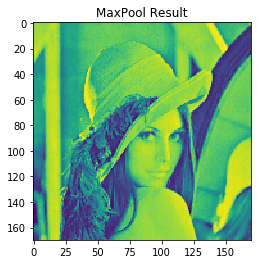

In [4]:
import numpy as np

class MaxPooling():
    def __init__(self,
                 indices,
                 input_func,
                 backprop
                ):
        ''''''
        self.input = input_func
        self.backprop = backprop
        self.n, self.v, self.u, self.c, self.shape = indices
        pass
    
    def pull_forward(self):
        for x in self.input():
            shape = (x.shape[0], self.shape[0], self.shape[1], -1)
            
            self.x = x[:,self.v,self.u,self.c]
            self.z = np.argmax(self.x, axis=1).T
            y = np.max(self.x, axis=1)
            self.y = y.reshape(shape)
            yield self.y
        pass
    
    def push_backward(self, dZ, lr):
        dZ = dZ.reshape(dZ.shape[0], -1)
        z = np.arange(self.dZ.shape[1])[:,None]
        dy = np.zeros(dZ.shape)
        dy[:,self.z,z] = dZ
        self.backprob(dy, lr)
        pass

## Test
def test_MaxPool():
    import matplotlib.pylab as plt
    from PIL import Image
    
    x = np.asarray(Image.open('Lenna.png'), dtype=float) / 255
    x, xs = shape_nvuc(x)
    def gen_Lenna():
         yield x
    
    mp = MaxPooling(
        indices=indices(xs,(1,3,3,1),(3,3)),
        input_func=gen_Lenna,
        backprop=None
    )
    
    for y in mp.pull_forward():
        print("Shape after pooling:", y.shape)
    
    plt.imshow(y[0,:,:,0])
    plt.title("MaxPool Result")
    plt.show()
    pass

test_MaxPool()

# 1. A CNN for MINIST

## Load n Prepare the MNIST Dataset

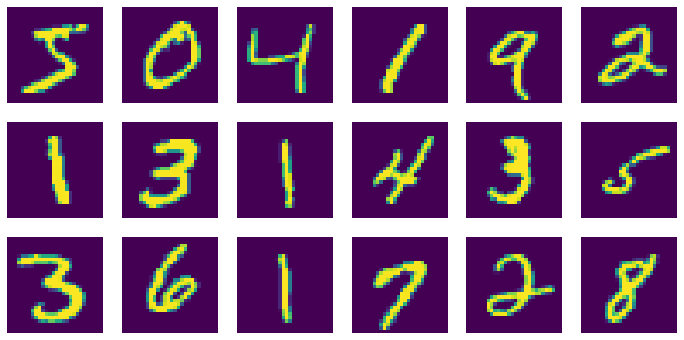

Labels: [5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8]
Input shape: (18, 28, 28, 1)


In [5]:
import numpy as np

def gen_UBYTES_data(filename, epochs=1, batch_size=1, split=1.0, norm=True, preload=False):
    #read header
    with open(filename, 'rb') as fid:
        mag = int.from_bytes(fid.read(4), byteorder='big')
        N = int.from_bytes(fid.read(4), byteorder='big')
        if mag == 2051:
            row = int.from_bytes(fid.read(4), byteorder='big')
            col = int.from_bytes(fid.read(4), byteorder='big')
        else:
            row = 1
            col = 1
        payload = fid.tell()
    
    #split
    if split > 0:
        N0 = 0
        N = int(N * split)
    else:
        N0 = N + int(N * split)
    
    #read payload batch wise
    step = 0
    if preload:
        with open(filename, 'rb') as fid:
            fid.seek(payload)
            batch = fid.read(N*row*col)
            pass
        
        batch = np.frombuffer(batch, dtype=np.uint8)
        if mag == 2051:
            if norm:
                batch = batch.astype(float) / 255
            batch = np.reshape(batch, (N, row, col, 1))
            
        for epoch in range(epochs):
            for n in range(N0,N,batch_size):
                trail = batch_size - (n % batch_size)
                step += trail
                yield batch[n:n+trail], epoch, step
    else:
        for epoch in range(epochs):
            for n in range(N0,N,batch_size):
                with open(filename, 'rb') as fid:
                    fid.seek(payload+n)
                    batch = fid.read(batch_size*row*col)
                    pass
                
                batch = np.frombuffer(batch, dtype=np.uint8)
                trail = batch_size - (n % batch_size)
                step += trail
                if mag == 2051:
                    if norm:
                        batch = batch.astype(float) / 255
                    batch = np.reshape(batch, (trail, row, col, 1))
                yield batch, epoch, step
    pass

def to_hot_vector(labels, k):
    N = labels.shape[0] if len(labels.shape) else 1
    hot = np.zeros((N, 1, 1, k))
    hot[range(N),:,:,labels] = 1
    return hot

def gen_MNIST_data(
    data="train-images.idx3-ubyte",
    labels="train-labels.idx1-ubyte",
    epochs=1,
    batch_size=1,
    split = 1.0,
    norm=True,
    preload=False
):
    gen_data = gen_UBYTES_data(data, epochs, batch_size, split, norm, preload)
    gen_labels = gen_UBYTES_data(labels, epochs, batch_size, split, norm, True)
    for data, label in zip(gen_data, gen_labels):
        X = data[0]
        T = to_hot_vector(label[0], 10)
        epoch = data[1]
        step = data[2]
        yield X, T, epoch, step

## test
def test_get_MNIST_data():
    %matplotlib inline
    import matplotlib.pylab as plt
    fig = plt.figure(figsize=(12,6))
    ax = fig.subplots(3,6)
    ax = np.reshape(ax, 6*3)

    ## get one batch and break
    for X, T, _, _ in gen_MNIST_data(
        "train-images.idx3-ubyte",
        "train-labels.idx1-ubyte",
        epochs=1,
        batch_size=6*3,
        norm=False
    ):
        for i, sample in enumerate(X):
            ax[i].set_axis_off()
            ax[i].imshow(np.squeeze(sample))
        break
    plt.show()
    print("Labels:", np.where(T)[3])
    print("Input shape:", X.shape)
test_get_MNIST_data()

## Configure CNN for MNIST


In [6]:
import numpy as np
from mynn import (
    NeuralNetwork,
    Layer,
    CrossEntropy,
    ArgMaxPooling,
    ReLU
)

def init_params(n, u, v, c, bias=True, init_func=np.random.randn):
    '''Initialize parameters.
    
    Args:
        n: Number of kernels.
        u, v: shape of the kernel.
        c: Number of channels of the kernel
        bias: True, if a bias should be used, otherwise False.
        init_func: Alter the initialization function.
            (default) np.random.randn
    Returns:
        kernels: A 4-dimensional matrix of weights.
        bias: Either 0 or a vector of biases for each node.
    '''
    kernels = init_func(n, v, u, c)
    return kernels, np.zeros(n) if bias else 0

def init_MNIST_cnn(epochs, batch_size):
    '''
    '''
    cnn = NeuralNetwork(
        train_set = lambda: gen_MNIST_data(
            "train-images.idx3-ubyte",
            "train-labels.idx1-ubyte",
            epochs, 
            batch_size,
            split=0.8
        ),
        val_set = lambda: gen_MNIST_data(
            "train-images.idx3-ubyte",
            "train-labels.idx1-ubyte",
            epochs=1, 
            batch_size=1,
            split=-0.2
        ),
        cost_func=CrossEntropy,
        loss_func=ArgMaxPooling
    )
    
    cnn.In = Layer(
        params=init_params(10,3,3,1),
        feed_func=Conv2D(stride=(2,2)),
        input_func=cnn.gen_input,
        backprop=None,
        act_func = ReLU
    ) #(28-2)/2=13
    
    cnn.Conv1 = Layer(
        params=init_params(10,4,4,10),
        feed_func=Conv2D(stride=(2,2)),
        input_func=cnn.In.pull_forward,
        backprop=cnn.In.push_backward,
        act_func = ReLU
    ) #(13-3)/2=5
    
    cnn.Out = Layer(
        params=init_params(10,5,5,10),
        feed_func=Conv2D(stride=(1,1)),
        input_func=cnn.Conv1.pull_forward,
        backprop=cnn.Conv1.push_backward,
        act_func = ReLU
    ) #(5-4)/1=1
    return cnn

cnn = init_MNIST_cnn(1, 1)
print(cnn.__dict__)

{'train_set': <function init_MNIST_cnn.<locals>.<lambda> at 0x00000184F673D948>, 'val_set': <function init_MNIST_cnn.<locals>.<lambda> at 0x00000184F673DC18>, 'cost': <class 'mynn.LossFunctions.CrossEntropy'>, 'loss': <class 'mynn.LossFunctions.ArgMaxPooling'>, 'training': False, 'In': <mynn.Layer.Layer object at 0x00000184F4B05248>, 'Conv1': <mynn.Layer.Layer object at 0x00000184F4B05288>, 'Out': <mynn.Layer.Layer object at 0x00000184F4B05308>}


## Train CNN for MNIST

In [ ]:
np.prod(np.ones(3))